(chap_files)=
# Files & file formats


:::{admonition} Chapter outline
:class: tip

* Image files consist of **pixel values** and **metadata**
* Some file formats are suitable for **data to analyze**, others for **data only to display**
* Metadata essential for analysis can be lost by saving in a **non-scientific file format**
* **Compression** can be either **lossless** or **lossy** -- with different results
* Original pixel values can be lost through **lossy compression**, **conversion to RGB**, or by **removing dimensions**
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

One of the surest ways to lose information when working with images is by making bad file format choices.

There is a vast array of file formats used to store images -- but not all formats support all the bit-depths, types and dimensions needed for scientific imaging.
Some formats tend to lose metadata, and some compromise pixel values through compression.

To avoid getting bogged down in file format intricacies, I want to give you the main messages of this chapter up-front:

:::{admonition} Working with image formats
:class: tip

* Always keep your original image files, in their original format
* During analysis:
  * Use software designed for scientific data (i.e. not a general photo editor)
  * If you need to save images, use the default file format for the software (e.g. TIFF for ImageJ)
  * **Check everything!** Make sure you can reopen the image after saving, and any pixel values, pixel size information and dimensions are retained exactly.
* Use general-purpose file formats (e.g. PNG, JPEG) for figures, presentations or websites -- but not later analysis
* Use TIFF cautiously, because it can be used both as a scientific format suitable for analysis and a general-purpose format suitable only for display
  * OME-TIFF is often a better alternative to TIFF, since it standardizes how the metadata is stored
:::

To help put this into practice, {numref}`table-file_formats` lists some of the most important image formats you need to know about when saving images yourself.

```{list-table} Some of the most useful file formats for bioimage analysis & display
:header-rows: 1
:name: table-file_formats

* - Format
  - Extensions
  - Main use
  - Compression
  - Comment
* - TIFF
  - .tif, .tiff
  - Analysis, display (print)
  - None, lossless, lossy
  - Very general image format
* - OME-TIFF
  - .ome.tif, .ome.tiff
  - Analysis, Display (print)
  - None, lossless, lossy
  - TIFF, with standardized metadata for microscopy
* - Zarr
  - .zarr
  - Analysis
  - None, lossless, lossy
  - Emerging format, great for big datasets -- but limited support currently
* - PNG
  - .png
  - Display (web, print)
  - Lossless
  - Small(ish) file sizes without compression artefacts
* - JPEG
  - .jpg, .jpeg
  - Display (web)
  - Lossy (usually)
  - Small file sizes, but visible artefacts
```

The rest of this chapter explains the key ideas.
Despite already having the conclusions, I hope you might persist with reading the rest anyway.
Understanding more about file formats can help enormously when it comes to choosing how to save images for different purposes, and diagnosing problems when the wrong formats have been used.

## Image file contents

An image file stored on computer contains two main things:

1. **Pixel values** -- the 'raw numbers' of the image
2. **Metadata** -- additional information, such as dimensions, image type, bit-depth, pixel sizes and microscope settings ('data about data')

The pixel values are clearly important.
But some pieces of the metadata are essential for the image data to be interpretable at all.
And if metadata such as the pixel size is incorrect or missing, measurements can also be wrong.
Therefore files must be saved in formats that preserve both the pixel values and metadata accurately if they are to be suitable for analysis later.

(sec_files_compression)=
### Pixel values & compression

Pixel values are represented using bytes.
As described in {ref}`chap_bit_depths`, an 8-bit image uses 1 byte per pixel, a 16-bit image uses 2 bytes per pixel and a 32-bit image uses 4 bytes per pixel.

However, the way these bytes are stored in the image file can depending upon whether compression is used.
There are three main options:

* **No compression**.
The bytes representing the pixels are stored directly in the file.
This means that the pixel values are preserved exactly, but the file can be quite large.
  * *Examples: TIFF (Uncompressed), ICS/IDS*
* **Lossless compression**.
The bytes representing the pixels are stored using a compression algorithm that (usually) results in less storage space being required, while making it possible to reconstruct the original values exactly by decompression.
Compared to uncompressed data, the file size using lossless compression is generally smaller but reading or writing the file takes longer.
  * *Examples: TIFF (LZW compressed), PNG, BMP, JPEG2000 (lossless)*
* **Lossy compression**.
The bytes representing the pixels are stored using a compression algorithm that does *not* have to be able to reconstruct the original values exactly.
This can result in dramatically smaller file sizes, but at a loss of information in the image -- and often visual artefacts.
  * *Examples: TIFF (JPEG compressed), JPEG, GIF, JPEG2000 (lossy)*

Probably the most famous file format that uses lossy compression is JPEG.

The basic idea of JPEG compression is that an image is split into 8x8 pixel blocks, and an approximation of the original values is stored rather than the exact values themselves.
Technically, this approximation involves the 'discrete cosine transform'; for our purposes, it's enough to know that JPEG artefacts tend to look 8x8 pixel squares, each containing wavy patterns, which are most evident when zooming in and/or cranking up the brightness and contrast to an extreme level ({numref}`fig-files_lossy`).

/tmp/ipykernel_2270/3583109659.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im_jpg = imread(bytes_jpg)
/tmp/ipykernel_2270/3583109659.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im_png = imread(bytes_png)
/tmp/ipykernel_2270/3583109659.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im_tif = imread(bytes_tif)


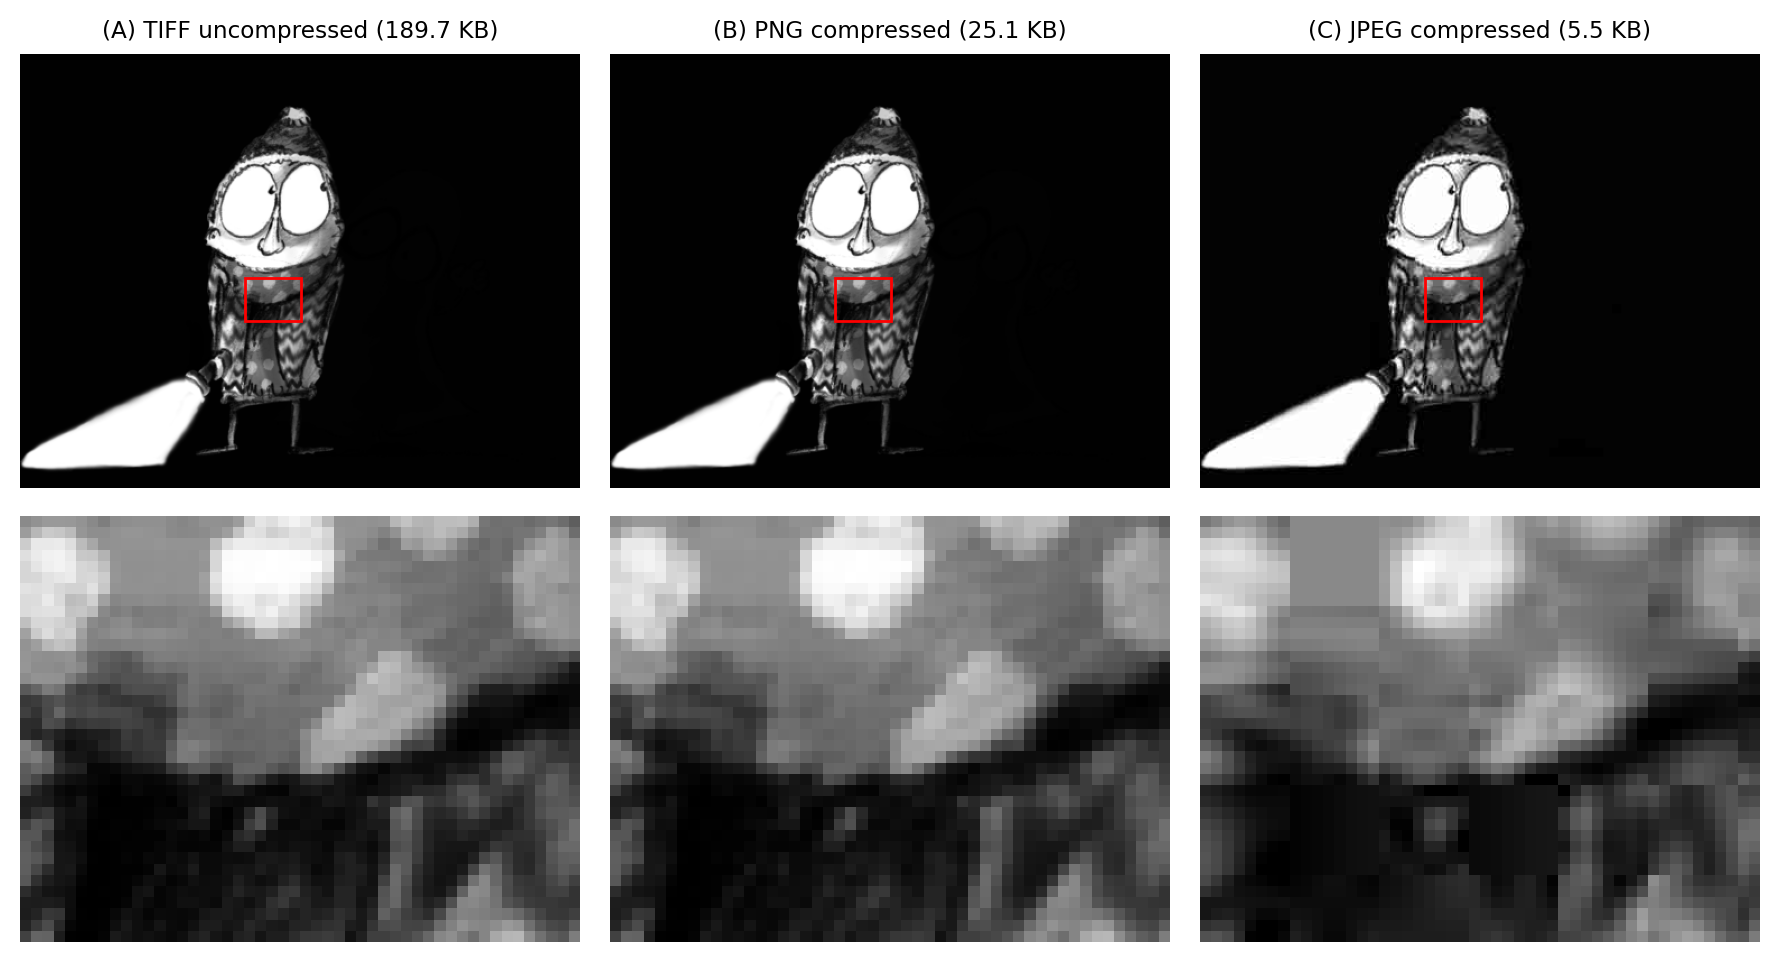

In [2]:
# Load image
im = load_image('spooked.png')

# Re-save as a JPEG; we do need to set the JPEG compression quite low to make the artefacts obvious
from imageio import imread, imwrite
bytes_jpg = imwrite("<bytes>", im, plugin='pillow', format="JPEG", quality=20)
im_jpg = imread(bytes_jpg)

# Re-save as a PNG
bytes_png = imwrite("<bytes>", im, format="PNG")
im_png = imread(bytes_png)

# Re-save as an uncompressed TIFF
bytes_tif = imwrite("<bytes>", im, format="TIFF")
im_tif = imread(bytes_tif)

def add_rectangle(x, y, width, height, axes=None, linewidth=1, edgecolor='r', facecolor='none', **kwargs):
    """
    Add rectangle to highlight selected region.
    """
    import matplotlib.patches as patches
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    if axes is None:
        axes = plt.gca()
    axes.add_patch(rect)

# Show image & details
fig = create_figure(figsize=(9, 5))
show_image(im_tif, pos=231, title=f'(A) TIFF uncompressed ({len(bytes_tif)/1024.0:.1f} KB)')
show_image(im_png, pos=232, title=f'(B) PNG compressed ({len(bytes_png)/1024.0:.1f} KB)')
show_image(im_jpg, pos=233, title=f'(C) JPEG compressed ({len(bytes_jpg)/1024.0:.1f} KB)')

r = 200
c = 200
w = 50
h = 38
show_image(im_tif[r:r+h, c:c+w], pos=234)
show_image(im_png[r:r+h, c:c+w], pos=235)
show_image(im_jpg[r:r+h, c:c+w], pos=236)

# Add rectangle to highlight detail area
for ax in fig.axes:
    add_rectangle(c, r, w, h, axes=ax)


plt.tight_layout()
glue_fig('fig_files_lossy', fig)

```{glue:figure} fig_files_lossy
---
align: center
name: fig-files_lossy
---
Examples of images saved with (A) no compression, (B) lossless compression, and (C) lossy JPEG compression. The pixel values of (A) and (B) are identical. Image (C) looks similar, but zooming in on a detailed region reveals characteristic JPEG artefacts.
```

:::{admonition} Compression quality
:class: tip

Lossy compression can often be varied with a 'compression quality' setting.
For a JPEG with a high quality setting, the 8x8 artefacts are likely to be much less obvious than they appear in {numref}`fig-files_lossy` -- although the pixel values are still modified.
Therefore it's a good idea to also use {ref}`statistics & histograms <chap_histograms>` to check for pixel changes.
:::


Based upon the importance of preserving pixel values, the easy rule is that:
:::{warning}
**Lossy compression is bad for analysis!**
:::

If in doubt, don't use lossy compression when working with scientific images.

The choice between 'no compression' and 'lossless compression' is a matter of preference, depending upon whether it's more important to you to save disk space or to open images quickly.
Compatibility is also a consideration if you want to open the images in different software: not all compression types are supported by all software.
So best check this before saving a lot of images in a format you might not be able to read elsewhere.


:::{admonition} How do I know if a file has been compressed?
An easy way to identify if an image has been lossily compressed is to look at the file extension, and check if it matches a format that uses lossy compression (e.g. *.jpeg*).
Easy, but not *always* successful.

One reason is that some file formats support both lossless and lossy compression.
For example, both JPEG and JPEG2000 (*not* the same thing!) are generally used with lossy compression but they both *could* be used for lossless compression as well.
Unless you've proof to the contrary, if you see a file with extension *.jpg*, *.jpeg*, *.jp2* then it's best to assume lossy compression has been used.

TIFF images are particularly tricky.
A TIFF image could contain uncompressed data, or data compressed using a variety of different methods -- both lossless and lossy, including JPEG.
To determine if a TIFF image has used lossy compression, more detective work may be needed (e.g. zooming in and hunting for artefacts, comparing pixel statistics with the original data file, or using software to check for metadata).
:::

````{tab-set}

```{tab-item} Question


It takes approximately 1 MB to store (1,000,000 bytes) an 8-bit uncompressed image with 1,000,000 pixels.

How much memory does it take to store a 16-bit image with the same number of pixels?

*You can ignore the tiny bit of extra space needed to store any associated metadata.*
```

```{tab-item} Answer

2 MB.

8 bits corresponds to 1 byte, so 16 bits correspond to 2 bytes.
We multiply the number of bytes per pixel by the number of pixels to get the minimum size required to store the uncompressed image.
```

````

````{tab-set}

```{tab-item} Question


Suppose you have an original image in TIFF format (no compression).
First, you save it as JPEG (lossy compression) to reduce the file size, then close it and throw away the TIFF.

Upon hearing JPEG is bad, you reopen the image and save it as TIFF  once more (no compression), throwing away the JPEG.
How does your final TIFF image look, and what is its file size?
```


```{tab-item} Answer

The final image will look exactly like the JPEG version, *but with the same file size as the original TIFF!*
As such, it has 'the worst of both worlds'.
```

````

### Core metadata

Pixel values are represented as a [stream of bits: ones and zeros](chap_bit_depths).
A few core pieces of metadata *must* be stored alongside these bits to interpret them as an image, such as the dimensions, bit-depth and type.
If this information is missing -- or wrong -- then the image usually either cannot be read, or looks strange in some way ({numref}`fig-files_core_metadata`).

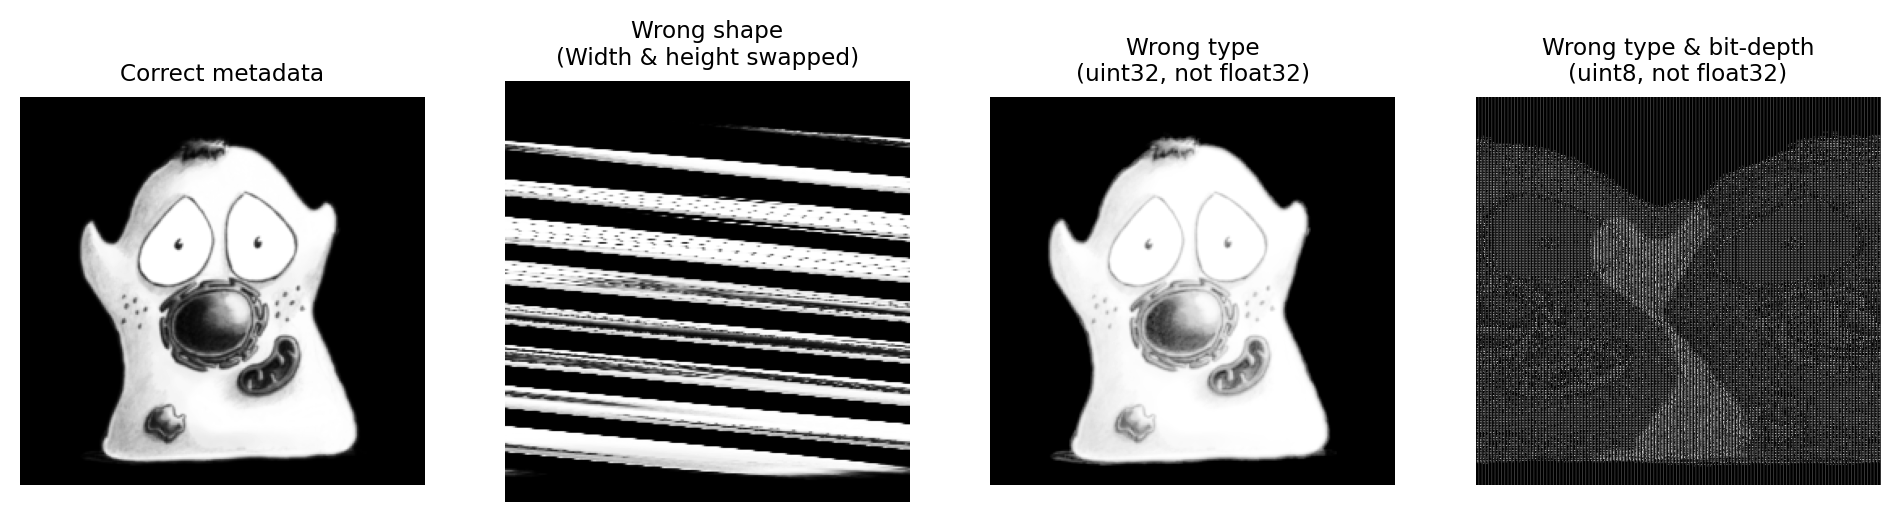

In [3]:
# Load image
im = load_image('happy_cell.tif')
assert im.ndim == 2

# Store the 'true' shape & byte array for the pixel values
shape = im.shape
raw_bytes = im.tobytes()
raw_dtype = im.dtype

# Generate new images from the raw byte arrays... some right, some wrong
im_correct = np.frombuffer(raw_bytes, dtype=raw_dtype).reshape(shape)
im_wrong_shape = np.frombuffer(raw_bytes, dtype=raw_dtype).reshape(shape[::-1])
im_wrong_type = np.frombuffer(raw_bytes, dtype=np.uint32).reshape(shape)
im_wrong_bits = np.frombuffer(raw_bytes, dtype=np.uint8).reshape([s * 2 for s in shape])

fig = create_figure(figsize=(12, 6))
show_image(im_correct, pos=141, title='Correct metadata')
show_image(im_wrong_shape, pos=142, title='Wrong shape\n(Width & height swapped)')
show_image(im_wrong_type, pos=143, title=f'Wrong type\n({im_wrong_type.dtype}, not {raw_dtype})')
show_image(im_wrong_bits, pos=144, title=f'Wrong type & bit-depth\n({im_wrong_bits.dtype}, not {raw_dtype})')

glue_fig('fig_files_core_metadata', fig)

```{glue:figure} fig_files_core_metadata
---
align: center
name: fig-files_core_metadata
---
Some examples of core metadata being read correctly or incorrectly.
```

*Most* of the time, we don't need to care about this because all image file formats store this core information, and software used to open the image *usually* interprets this correctly.

But it isn't unheard of for some fancy new format to store the core metadata in a way that cannot be properly read and interpreted by other software.
If you try to open your images and find they look very odd, you should be aware that there might be a metadata problem -- and you might need to contact the developer of the software to figure out what has gone wrong.

More commonly, the choice of file format impacts what type of image can be stored.
For example, PNG or JPEG images are limited to 2D integer data, optionally with 1, 3 or 4 channels; they do not support (for example) 32-bit floating point images, z-stacks or time series.
Saving a 5D floating point image as a JPEG or PNG therefore inherently involves converting the image type and discarding information.

### Additional metadata

The most important piece of 'non-core' metadata is the {ref}`pixel size <chap_pixel_size>`.
Unlike core metadata, it is *not* necessary for a file format to preserve the pixel size for an image to be opened and appear 'correct'.

This is a problem because if the pixel size is incorrect or missing, it remains possible to make length, area or volume measurements within an image -- but these measurements are likely to be wrong.

In microscopy, the pixel size is typically represented as a value in µm/pixel.
Saving in some file formats (e.g. JPEG and PNG) tends to lose pixel size information.
Others (e.g. TIFF) *might* preserve the pixel size, *might* lose it, or *might* convert it to something else entirely.

This should sound odd, scary and outrageous.
Losing pixel size information is one thing, but why would any sneaky software just change the value to something else??!?

To explain this, we need to remember that most images aren't intended for analysis.
Most are intended only for display.
And, for display, size can have a different meaning.

Many researchers already encounter this when it comes to publishing papers.
Journals often require that figures are submitted at a sufficiently high resolution for printing, with the resolution defined in terms of **dots per inch (*dpi*)**.
For example, an image might be requested that is at least 300 dpi; if it should be printed at a size of 2 x 2 inches, then it should be at least 600 x 600 pixels.

For an image with a dpi of 300, one *could* argue that a single pixel has a size of 1/300 inches.
In this case, size is related to display.
It doesn't matter what the image depicts -- it could be a cell, a person, a building, a galaxy -- or tell us anything about its scale.
In this case, the pixel size is only telling us how the image ought to be displayed.

When it comes to TIFF images, the pixel size for science or the pixel size for display (i.e. dpi) might be stored *in exactly the same part of the file*.
Therefore what this value actually means depends entirely upon which software wrote the image, and whether it was more concerned with analysis or display.

For that reason:

:::{warning}
**Always sanity-check pixel size values!**
:::

How to do that will depend upon which software you are using: each may display pixel size information in a different place.
But one universal rule is to use whatever knowledge you have about whatever is in your images.

For example, suppose you have an image of cells.
A quick internet search can reveal a typical diameter of a nucleus (perhaps 5-20&nbsp;µm).
Therefore you could spend a few minutes measuring some nucleus diameters to see if they are close to this value.
If so, it does not prove the pixel size is correct but it does give some added confidence; if the value is far from what is expected, then it is a warning that the pixel size is wrong.

## Choosing file formats

The right choice of file format depends upon when you are saving the image, and what you will want to do with it.
Three main scenarios are described below.

### During acquisition

:::{margin}
Examples formats for specific microscopes include *.lif* (Leica), *.czi* (Zeiss), *.nd2* (Nikon), *.vsi* (Olympus)... with many more.
:::

The general rule is to
:::{admonition} Saving images during acquisition
:class: tip
Use the default file format for your microscope and acquisition software
:::

The rationale is that the manufacturer's format ought to preserve all the information and metadata.
Often, the acquisition software supports saving the data in some other way -- but that can be risky.
There's a strong chance that at least some metadata could be lost.
Sometimes, the alternative export might do even worse things -- such as convert the data to RGB.

The disadvantage of this is that microscopy formats are usually uncommon in the rest of the world, which means your images might be hard to open in other software.

**Fortunately, there is a magnificent open-source project to help with this: [**Bio-Formats**](https://www.openmicroscopy.org/bio-formats/).**

Bio-Formats enables a [wide range of different formats](https://docs.openmicroscopy.org/bio-formats/latest/supported-formats.html) to be read by many different software applications.
It's already available within Fiji and QuPath by default, or can be installed as a plugin for ImageJ.
Although it's written in Java, Bio-Formats can also be used within some Python applications.

*If* you are unlucky enough that the native format for your microscope isn't supported by Bio-Formats, you might need to export it in a different format for use elsewhere.
But if you do this, it's best to retain a copy of the original data anyway -- so you can always refer to it using the original acquisition software to check what (if anything) might have been lost in the export.


### During analysis

If you want to save an image during analysis, the rule is
:::{admonition} Saving images during analysis
:class: tip
Use the default file format for the analysis software you're using -- or OME-TIFF
:::
Like the rule for acquisition, the idea is that this will generally preserve as much metadata as possible.

For ImageJ, the default format is an uncompressed TIFF image.
This supports 8-bit, 16-bit and 32-bit images with up to 5 dimensions, squeezing the key metadata required by ImageJ (e.g. pixel size) into one of the TIFF fields.
All of this information should then be available if you open the image again in ImageJ or Fiji -- although it is not *necessarily* preserved if you open the TIFF in other software, which may not know how to interpret ImageJ's metadata.
So if this is important to you, you'll need to check.

*However*, this might not be the best choice if you want to continue working with your image in different software.
In that case, it might take some exploration to see which formats enable metadata to be saved in a way that your preferred software applications recognize.

If you're using software that incorporates Bio-Formats, the best option is likely to be OME-TIFF.
Bio-Formats can read and write OME-TIFF images, which has a very well-defined standard for storing metadata (developed by the group behind Bio-Formats itself).
This opens up more possibilities, such as writing TIFFs that include either lossless or lossy compression.
OME-TIFF can also contain a lot more metadata than an ImageJ TIFF can, including things like stage position, laser power etc.


### For display

When it comes to displaying images, we usually only need a format that can support RGB images.
Since we won't use the image for further analysis, we don't need to preserve the pixel size and don't *necessarily* have to avoid compression artefacts.
My personal preferred formats for different scenarios are:

* **Journal figure: TIFF.** <br /> Often the journal requests this anyway. Even if I'm not convinced it always makes sense.
* **Presentation: PNG.** <br /> File size is not usually a problem, and PNG provides some compression without introducing artefacts.
* **Website: JPEG or PNG**, <br />JPEG (usually) because smaller file sizes mean the website can load quicker (and eat less data).
But PNG for images that contain few colors, including most 'artificial' images such as drawings, dialog boxes or logos.
JPEG artifacts can look especially ugly in such cases, while PNG can compress them very well.

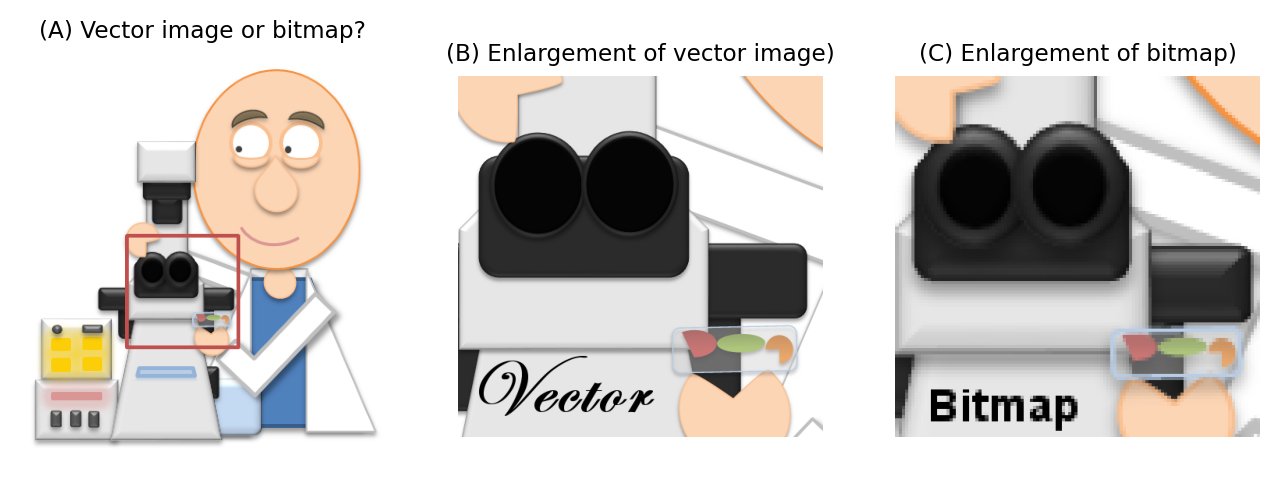

In [4]:
fig = create_figure(figsize=(8, 4))
show_image('images/vb_scientist_orig.png', title='(A) Vector image or bitmap?', pos=131)
show_image('images/vb_scientist_vector_labelled.png', title='(B) Enlargement of vector image)', pos=132)
show_image('images/vb_scientist_bitmap_labelled.png', title='(C) Enlargement of bitmap)', pos=133)
glue_fig('fig_files_vector_bitmap', fig)

````{admonition} Creating figures for publication

Preparing figures for publication can be a bewildering process.
To begin with, it's necessary to make another distinction between image types, one of which has not been discussed here so far:

* **Bitmaps**. These are composed of individual pixels: e.g. photographs, or all the microscopy images we are concerned with here.
* **Vector images**. These are composed of lines, curves, shapes or text.  The instructions needed to draw the image (i.e. coordinates, equations, fonts) are stored rather than pixels, and then the image is recreated from these instructions when necessary.

Every other part of this handbook concentrates on bitmap images.
Vector images are quite different.

If you scale a 2D bitmap image by doubling its width and height, then it will contain four times as many pixels.
Guesses need to be made about how to fill in the extra information properly (which is the problem of **interpolation**), and the result generally looks less sharp than the original.
But if you double the size of a vector image, it's just a matter of updating the maths needed to draw the image accordingly, and the result looks just as sharp as the original.

Vector images are therefore best for things like diagrams, histograms, plots and charts, because they can be resized freely and still look good.
Also, they often have tiny file sizes because only a few instructions to redraw the image need to be kept, whereas a huge number of pixels might be required to store sufficiently nice, sharp text in a bitmap.
But bitmaps are needed for images formed from detecting light, which cannot be reduced to a few simple equations and instructions.

Finally, some versatile file formats, such as PDF or EPS, can store both kinds of image: perhaps a bitmap with some text annotations on top.
If you are including text or diagrams, these formats are generally best.
But if you only have bitmaps without annotations of any kind, then TIFF is probably the most common file format for creating figures.

```{glue:figure} fig_files_vector_bitmap
---
align: center
name: fig-vector_bitmap
---

When viewed from afar, it may be difficult to know whether an image is a vector or a bitmap (A) because they can sometimes look identical (although a photograph or micrograph will always be a bitmap). However, when enlarged a vector image will remain sharp (B), whereas a bitmap will not (C).
```

````

(sec_files_pyramidal)=
## Pyramidal images

Finally, we end with a few words on **pyramidal images**: a type of image that is becoming increasingly common.

Modern bioimages can be *huge*.
It's not uncommon for a single image to contain many gigabytes of pixel data, making it infeasible to open the full image in one go.

However, for visualization or analysis we often don't *need* all the pixels at once.
For example, when viewing an image we only really need to access the pixels that are visible on screen at any moment -- at the magnification at which they are being viewed.

Pyramidal image files help overcome this by using two tricks:
* They store the image as separate chunks (often called 'tiles', if they are 2D)
* They store the same image at different resolutions in the same file

```{figure} ./images/pyramid_small.png
---
name: fig-files_pyramidal
align: center
---
Schematic diagram of a pyramidal image. The image itself (left) is broken into chunks and stored at multiple resolutions. The chunks needed to display the current field of view (top right) are highlighted in yellow.
The original whole slide image here is from the [CAMELYON](https://camelyon16.grand-challenge.org) grand challenge.
```

Software designed to handle pyramidal images can then dip into the image file and read **only the part of the image that is needed at the time**.
This is often only a tiny proportion of the entire dataset.

Pyramidal images are especially common for pathology, although they are starting to be used more for other applications.
[QuPath](https://qupath.github.io) is open source software that is designed specifically to handle pyramidal images efficiently (and happens to also be the software that I wrote and maintain, because I wasn't able to do the analysis with other open source tools at the time).
Although QuPath can do a lot of things on its own, it can also be used [with ImageJ](https://qupath.readthedocs.io/en/stable/docs/advanced/imagej.html).